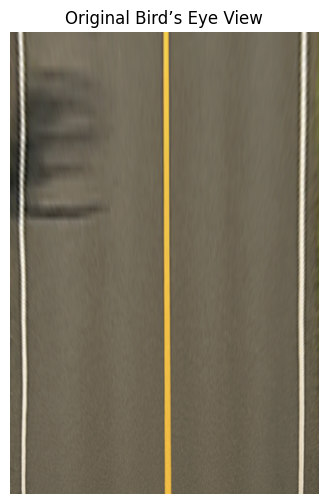

In [1]:
# ============================================================
# Step 0: Setup
# ============================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial

# Load the Bird’s Eye View image (the top-down one)
img_path = "./init_photo.png"  # update path if needed
bev = cv2.imread(img_path)

# Display the original BEV
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(bev, cv2.COLOR_BGR2RGB))
plt.title("Original Bird’s Eye View")
plt.axis("off")
plt.show()


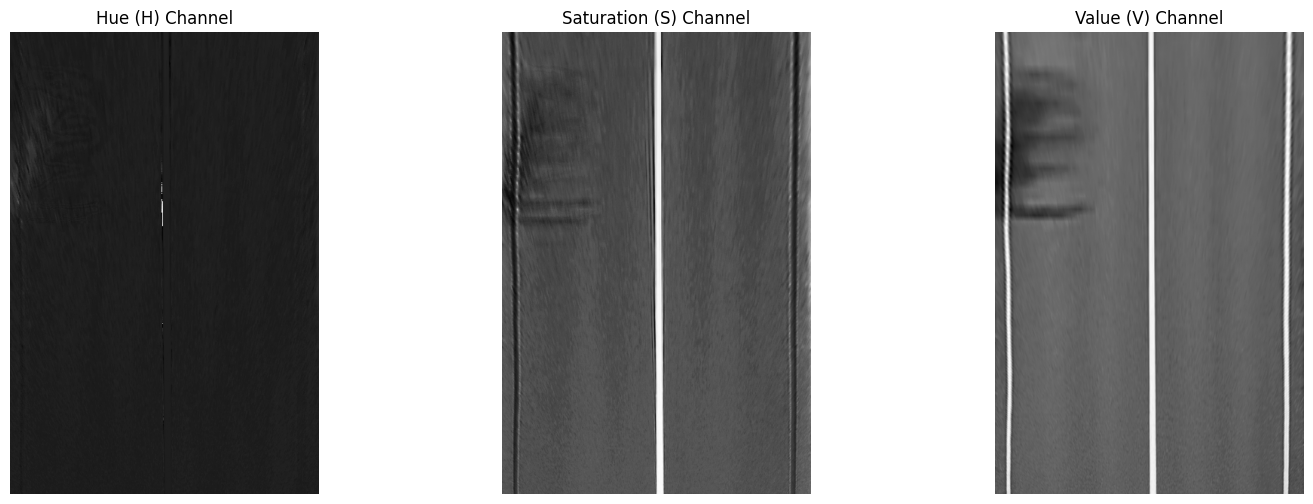

In [2]:
# ============================================================
# Step 1: Convert BGR → HSV and visualize each channel
# ============================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read BEV image
bev = cv2.imread("./init_photo.png")  # update if needed
hsv = cv2.cvtColor(bev, cv2.COLOR_BGR2HSV)

# Split into individual channels
H, S, V = cv2.split(hsv)

# Visualize all three channels
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(H, cmap='gray')
axs[0].set_title("Hue (H) Channel")
axs[0].axis("off")

axs[1].imshow(S, cmap='gray')
axs[1].set_title("Saturation (S) Channel")
axs[1].axis("off")

axs[2].imshow(V, cmap='gray')
axs[2].set_title("Value (V) Channel")
axs[2].axis("off")

plt.show()


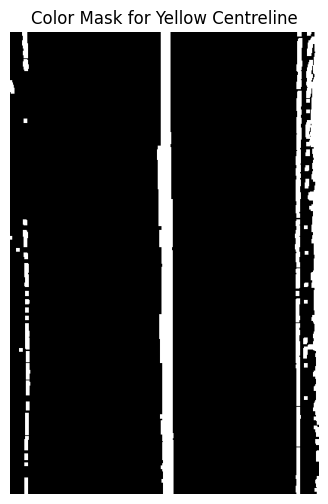

In [3]:
# ============================================================
# Step 2: Color Mask
# ============================================================
# Define HSV range for yellow (tune if needed)
lower_yellow = np.array([15, 80, 80])
upper_yellow = np.array([40, 255, 255])

color_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

# Fill small gaps
kernel = np.ones((5, 5), np.uint8)
color_mask = cv2.dilate(color_mask, kernel, iterations=1)

plt.figure(figsize=(8, 6))
plt.imshow(color_mask, cmap='gray')
plt.title("Color Mask for Yellow Centreline")
plt.axis("off")
plt.show()


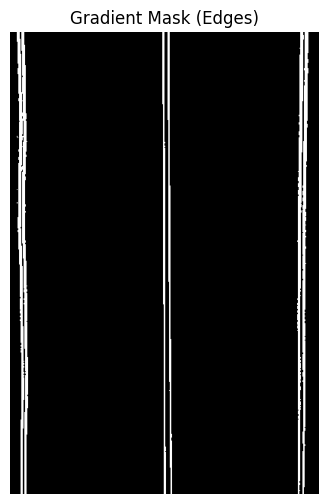

In [4]:
# ============================================================
# Step 3: Gradient Mask
# ============================================================
gray = cv2.cvtColor(bev, cv2.COLOR_BGR2GRAY)

# Compute Sobel gradients
grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
grad_mag = cv2.magnitude(grad_x, grad_y)

# Normalize and convert to uint8
grad_mag = np.uint8(255 * grad_mag / np.max(grad_mag))

# Threshold for strong gradients
t_min, t_max = 50, 255
gradient_mask = cv2.inRange(grad_mag, t_min, t_max)

plt.figure(figsize=(8, 6))
plt.imshow(gradient_mask, cmap='gray')
plt.title("Gradient Mask (Edges)")
plt.axis("off")
plt.show()


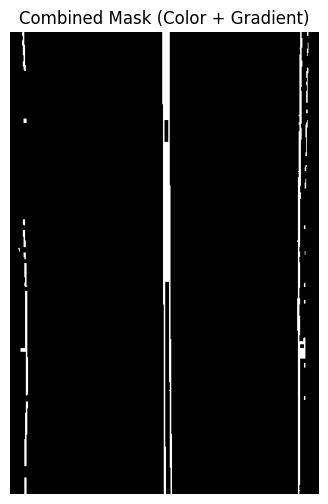

In [5]:
# ============================================================
# Step 4: Combine Masks
# ============================================================
combined_mask = cv2.bitwise_and(color_mask, gradient_mask)

# Optional morphology to refine
combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(8, 6))
plt.imshow(combined_mask, cmap='gray')
plt.title("Combined Mask (Color + Gradient)")
plt.axis("off")
plt.show()


Collected 153 points for polynomial fitting.


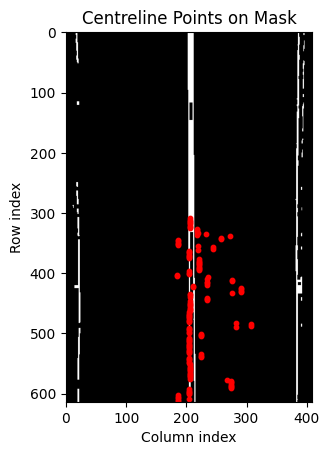

In [6]:
# ============================================================
# Step 5: Find Centreline points (rows, cols)
# ============================================================

import numpy as np
import cv2

# mask_combined = result from Step 4 (binary mask of the centreline)
height, width = combined_mask.shape

rows = []
cols = []

# Parameters
stride = 2       # process every 2nd row to speed up
tE = 2          # minimum number of white pixels required to consider the row valid

for r in range(height - 1, height // 2, -stride):  # from bottom → middle
    white_pixels = np.where(combined_mask[r, :] > 0)[0]  # indices of white pixels in row
    
    if len(white_pixels) > tE:
        c = np.mean(white_pixels)   # average column index
        rows.append(r)
        cols.append(c)

rows = np.array(rows)
cols = np.array(cols)

print(f"Collected {len(rows)} points for polynomial fitting.")

# Plot the binary mask
plt.imshow(combined_mask, cmap='gray')
plt.scatter(cols, rows, color='red', s=10)  # overlay centreline points
# plt.gca().invert_yaxis()  # optional: invert y-axis to match image coordinates
plt.title("Centreline Points on Mask")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()
# plt.figure(figsize=(8, 6))
# plt.imshow(combined_mask, cmap='gray')
# if len(rows) > 0:
#     plt.scatter(cols[0], rows[1], c='r', s=10)
# plt.title("Detected Centreline Points (Adaptive)")
# plt.axis("off")
# plt.show()

Initial fit coefficients: c2=-0.000506, c1=0.464307, c0=116.20
Outlier rejection threshold: 17.50 px
Inliers kept: 107 / 153 points
Refined fit: c2=-0.000404, c1=0.337966, c0=143.74, MSE=74.16


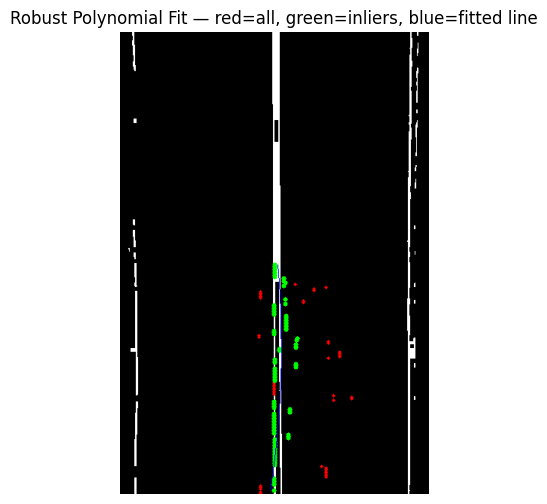

In [9]:
# ============================================================
# Step 6 (Improved): Robust polynomial fit with outlier rejection
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import cv2

if len(rows) == 0:
    raise ValueError("No points found for polynomial fitting — check Step 5 thresholds.")

# --- 1) Initial least squares fit (2nd-order) ---
A = np.vstack([rows**2, rows, np.ones_like(rows)]).T
coeffs, _, _, _ = np.linalg.lstsq(A, cols, rcond=None)
c2, c1, c0 = coeffs

def poly(r):
    return c2 * r**2 + c1 * r + c0

# --- 2) Compute residuals ---
pred_cols = poly(rows)
residuals = np.abs(pred_cols - cols)

# --- 3) Identify inliers using residual threshold ---
threshold = np.percentile(residuals, 70)  # keep ~70% of best points
inliers = residuals < threshold
outliers = ~inliers

print(f"Initial fit coefficients: c2={c2:.6f}, c1={c1:.6f}, c0={c0:.2f}")
print(f"Outlier rejection threshold: {threshold:.2f} px")
print(f"Inliers kept: {np.sum(inliers)} / {len(rows)} points")

# --- 4) Refit polynomial using only inliers ---
rows_in = rows[inliers]
cols_in = cols[inliers]
A_in = np.vstack([rows_in**2, rows_in, np.ones_like(rows_in)]).T
coeffs_in, _, _, _ = np.linalg.lstsq(A_in, cols_in, rcond=None)
c2, c1, c0 = coeffs_in

def poly_refined(r):
    return c2 * r**2 + c1 * r + c0

pred_in = poly_refined(rows_in)
mse_in = np.mean((pred_in - cols_in) ** 2)
print(f"Refined fit: c2={c2:.6f}, c1={c1:.6f}, c0={c0:.2f}, MSE={mse_in:.2f}")

# --- 5) Visualization ---
vis = cv2.cvtColor(combined_mask, cv2.COLOR_GRAY2BGR)

# draw all raw points in red
for (c, r) in zip(cols, rows):
    cv2.circle(vis, (int(c), int(r)), 2, (0, 0, 255), -1)

# draw inlier points in green
for (c, r) in zip(cols_in, rows_in):
    cv2.circle(vis, (int(c), int(r)), 3, (0, 255, 0), -1)

# draw fitted polynomial in blue
y_vals = np.arange(np.min(rows_in), np.max(rows_in), 1)
x_vals = poly_refined(y_vals)
for (x, y) in zip(x_vals, y_vals):
    if 0 <= int(x) < vis.shape[1] and 0 <= int(y) < vis.shape[0]:
        vis[int(y), int(x)] = (255, 0, 0)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Robust Polynomial Fit — red=all, green=inliers, blue=fitted line")
plt.axis("off")
plt.show()


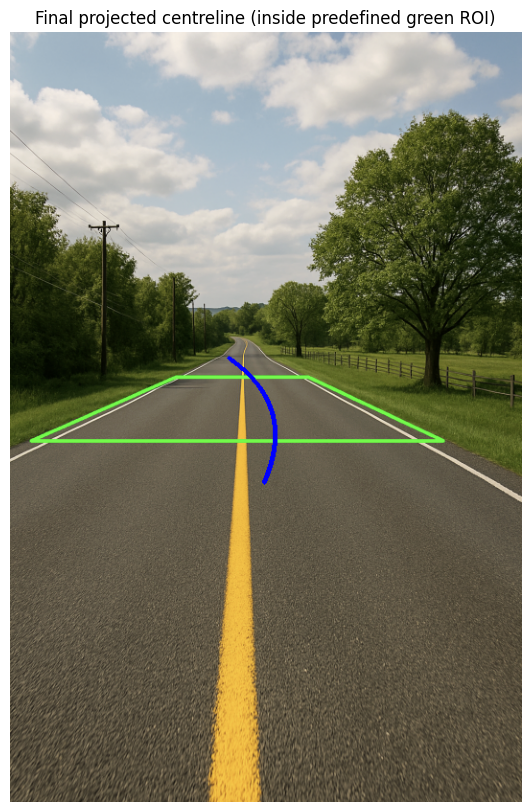

In [12]:
# ============================================================
# Step 7: Project fitted BEV polynomial inside predefined ROI
# ============================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Load perspective image with the green ROI already drawn ---
persp = cv2.imread("./sector.png")

# --- 2) Define ROI corners (must match exactly the green box corners) ---
# Order: top-left, top-right, bottom-right, bottom-left
src_quad = np.array([
    [140, 340],   # top-left
    [390, 340],   # top-right
    [470, 470],   # bottom-right
    [70, 470]     # bottom-left
], dtype=np.float32)

# --- 3) Define BEV rectangle corners (matches BEV image size) ---
h_bev, w_bev = combined_mask.shape
dst_quad = np.array([
    [0, 0],
    [w_bev - 1, 0],
    [w_bev - 1, h_bev - 1],
    [0, h_bev - 1]
], dtype=np.float32)

# --- 4) Compute homography (BEV → perspective) ---
H_bev2p = cv2.getPerspectiveTransform(dst_quad, src_quad)

# --- 5) Sample the fitted polynomial in BEV coordinates ---
y_vals = np.linspace(0, h_bev - 1, num=h_bev)
x_vals = poly_refined(y_vals)
valid = (x_vals >= 0) & (x_vals < w_bev)
pts_bev = np.stack([x_vals[valid], y_vals[valid]], axis=1).astype(np.float32).reshape(-1, 1, 2)

# --- 6) Project polynomial points into the perspective image ---
pts_persp = cv2.perspectiveTransform(pts_bev, H_bev2p).reshape(-1, 2)
pts_persp_int = np.round(pts_persp).astype(int)

# --- 7) Draw the blue polynomial line inside the ROI ---
vis = persp.copy()
cv2.polylines(vis, [pts_persp_int], isClosed=False, color=(255, 0, 0), thickness=3)

plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Final projected centreline (inside predefined green ROI)")
plt.axis("off")
plt.show()
